### Import libraries (Might not need all of them)

In [56]:
import tensorflow as tf
import keras
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import SVG, display
import re, os
from string import printable
import string
from string import punctuation
import pandas as pd
from sklearn.utils import shuffle
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import json
from tensorflow.python.client import device_lib
from PIL import Image
import copy

py.init_notebook_mode(connected=True)

# For reproducibility
np.random.seed(123)

### Import Keras libraries (Might not need all of them)

In [81]:
from keras.models import  Sequential, Model, model_from_json, load_model
from keras import regularizers
from keras import backend as K
from keras.preprocessing import sequence
from keras.layers.core import Dense, Dropout, Activation, Lambda, Flatten, Reshape
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2
from keras.layers import Input, LSTM, Embedding, BatchNormalization, MaxPooling1D, concatenate, Dense
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.layers import Bidirectional, SimpleRNN
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import TensorBoard, ModelCheckpoint

### Read data Preprocess

In [82]:
df = pd.read_csv("data_for_sarcasm_detection_RD.txt", sep='\t', names = ["sarcasm_flag", "tweet"])

In [83]:
df = shuffle(df)
print(list(df))
print(df.shape)

['sarcasm_flag', 'tweet']
(41755, 2)


#### Remove hastags and urls

In [84]:
def tweet_cleanup_urls_hashtags(tweet):   
    ## Remove urls and hashtags
    pattern1 = r"http\S+"
    pattern2 = r"@\S+"
    pattern3 = r"#\S+"
    combined_pattern = r'|'.join((pattern1, pattern2, pattern3))
    result = re.sub(combined_pattern, "", tweet)
    return(result)

In [85]:
df['tweet'] = df['tweet'].apply(tweet_cleanup_urls_hashtags)

#### Convert tweet to lower case

In [87]:
df['tweet'] = df['tweet'].str.lower()
df.head()

,sarcasm_flag,tweet
9205,1,funny the founder of the birther movement try...
72,1,"how do i look? "" friend : "" you look fine. "" g..."
24583,0,beta convention was so much fun! can't wait fo...
34249,0,this is pathetic spin when he clearly meant ...
35164,1,lol i love math but hate my geometry teacher


#### Remove punctuations

In [88]:
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

In [89]:
df['tweet'] = df['tweet'].map(lambda x: strip_punctuation(x))
df.head()

,sarcasm_flag,tweet
9205,1,funny the founder of the birther movement try...
72,1,how do i look friend you look fine good fr...
24583,0,beta convention was so much fun cant wait for ...
34249,0,this is pathetic spin when he clearly meant ...
35164,1,lol i love math but hate my geometry teacher


### Build model using simple LSTM

In [90]:
# Convert raw URL string in list of lists where characters that are contained in "printable" 
# are stored encoded as integer 
tw_int_tokens = [[printable.index(x) + 1 for x in tweet if x in printable] for tweet in df.tweet]

In [91]:
# Cut URL string at max_len or pad with zeros if shorter
max_len=250
X = sequence.pad_sequences(tw_int_tokens, maxlen=max_len)

In [92]:
# Extract labels form df to numpy array
target = np.array(df.sarcasm_flag)

In [93]:
print('Matrix dimensions of X: ', X.shape, 'Vector dimension of target: ', target.shape)

Matrix dimensions of X:  (41755, 250) Vector dimension of target:  (41755,)


In [94]:
# Simple Cross-Validation: Split the data set into training and test data
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, target, test_size=0.2, random_state=33)

In [95]:
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)

In [96]:
## Simple LSTM

max_len=250
emb_dim=32
max_vocab_len=100
lstm_output_size=32
W_reg=regularizers.l2(1e-4)

# Input
main_input = Input(shape=(max_len,), dtype='int32', name='main_input')

# Embedding layer
emb = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len,
                dropout=0.2, W_regularizer=W_reg)(main_input) 

# LSTM layer
lstm = LSTM(lstm_output_size)(emb)
lstm = Dropout(0.5)(lstm)
lstm = Dropout(0.5)(lstm)
        

# Output layer (last fully connected layer)
output = Dense(2, activation='sigmoid', name='output')(lstm)


# Compile model and define optimizer
model = Model(input=[main_input], output=[output])
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [97]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 250)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 250, 32)           3200      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 2)                 66        
Total params: 11,586
Trainable params: 11,586
Non-trainable params: 0
_________________________________________________________________


In [98]:
batch_size = 32
num_epochs = 50

In [99]:
modelrnn_train = model.fit(x_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=num_epochs)

Train on 26723 samples, validate on 6681 samples
Epoch 1/50
26723/26723 [==============================] - 153s 6ms/step - loss: 0.6642 - acc: 0.6460 - val_loss: 0.5901 - val_acc: 0.6999
Epoch 2/50
26723/26723 [==============================] - 151s 6ms/step - loss: 0.4898 - acc: 0.7787 - val_loss: 0.3956 - val_acc: 0.8322
Epoch 3/50
26723/26723 [==============================] - 157s 6ms/step - loss: 0.4163 - acc: 0.8205 - val_loss: 0.3746 - val_acc: 0.8396
Epoch 4/50
26723/26723 [==============================] - 155s 6ms/step - loss: 0.4019 - acc: 0.8278 - val_loss: 0.3744 - val_acc: 0.8358
Epoch 5/50
26723/26723 [==============================] - 159s 6ms/step - loss: 0.3957 - acc: 0.8316 - val_loss: 0.3690 - val_acc: 0.8383
Epoch 6/50
26723/26723 [==============================] - 163s 6ms/step - loss: 0.3916 - acc: 0.8327 - val_loss: 0.3657 - val_acc: 0.8428
Epoch 7/50
26723/26723 [==============================] - 147s 6ms/step - loss: 0.3881 - acc: 0.8342 - val_loss: 0.3652 - v

### Save model

In [100]:
# Serialize model to JSON
model_digit_json = model.to_json()
with open("model_sarcasm.json", "w") as json_file:
    json_file.write(model_digit_json)
    
# Serialize weights to HDF5
model.save_weights("model_sarcasm.h5")
print("Saved model to disk")

Saved model to disk


### Plot model accuracy

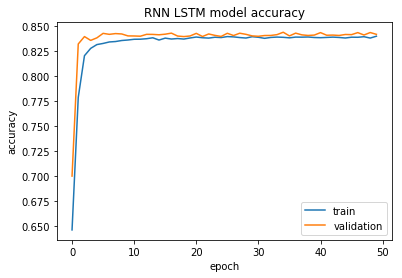

In [101]:
plt.plot(modelrnn_train.history['acc'])
plt.plot(modelrnn_train.history['val_acc'])
plt.title('RNN LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='bottom right')
plt.show()

### Plot model loss

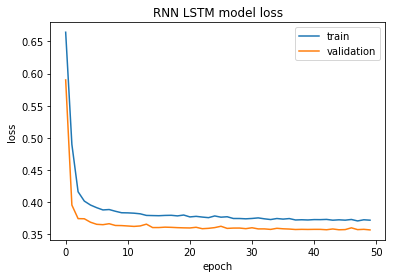

In [102]:
plt.plot(modelrnn_train.history['loss'])
plt.plot(modelrnn_train.history['val_loss'])
plt.title('RNN LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Evaluate model

In [103]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("\nTest Accuracy: %.2f%%" % (accuracy*100))

8351/8351 [==============================] - 5s 546us/step

Test Accuracy: 84.00%
